In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.utils import axes_dict, plot_some, plot_history
from stardist import fill_label_holes, random_label_cmap
from stardist import Config, StarDist, StarDistData

np.random.seed(42)
lbl_cmap = random_label_cmap()

/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/data/u934/service_imageri

In [2]:
X = sorted(glob('/data/u934/service_imagerie/v_kapoor/HEARD/UNet-training/images/*.tif'))
Y = sorted(glob('/data/u934/service_imagerie/v_kapoor/HEARD/UNet-training/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))


In [3]:
X = list(map(imread,X))
Y = list(map(imread,Y))


In [4]:
X = [normalize(x,1,99.8) for x in tqdm(X)]
Y = [fill_label_holes(y.astype(int)) for y in tqdm(Y)]




100%|██████████| 93/93 [00:08<00:00, 10.56it/s] 


In [5]:
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = int(round(0.15 * len(X)))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 



print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))
print(X[0].shape[0])

number of images:  93
- training:        79
- validation:      14
512


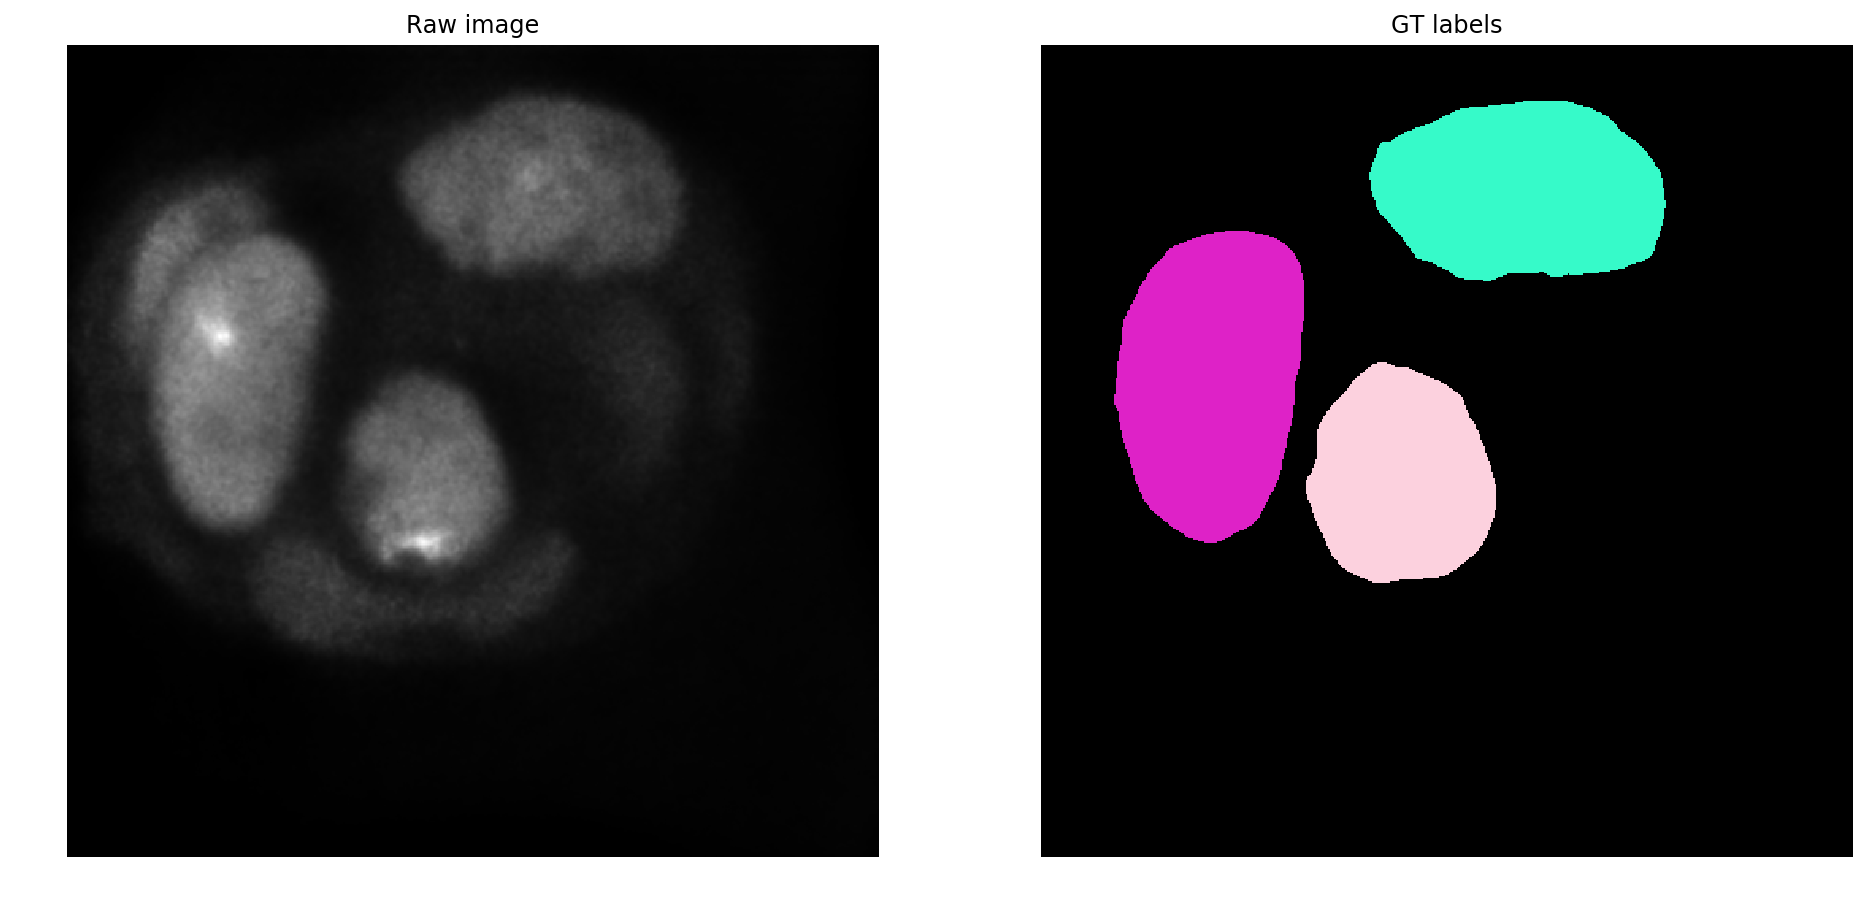

In [6]:
i = 9
img, lbl = X[i], Y[i]
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

In [7]:
np.random.seed(42)
data = StarDistData(X,Y,batch_size=1,n_rays=128,patch_size=(300,300),shape_completion=False)

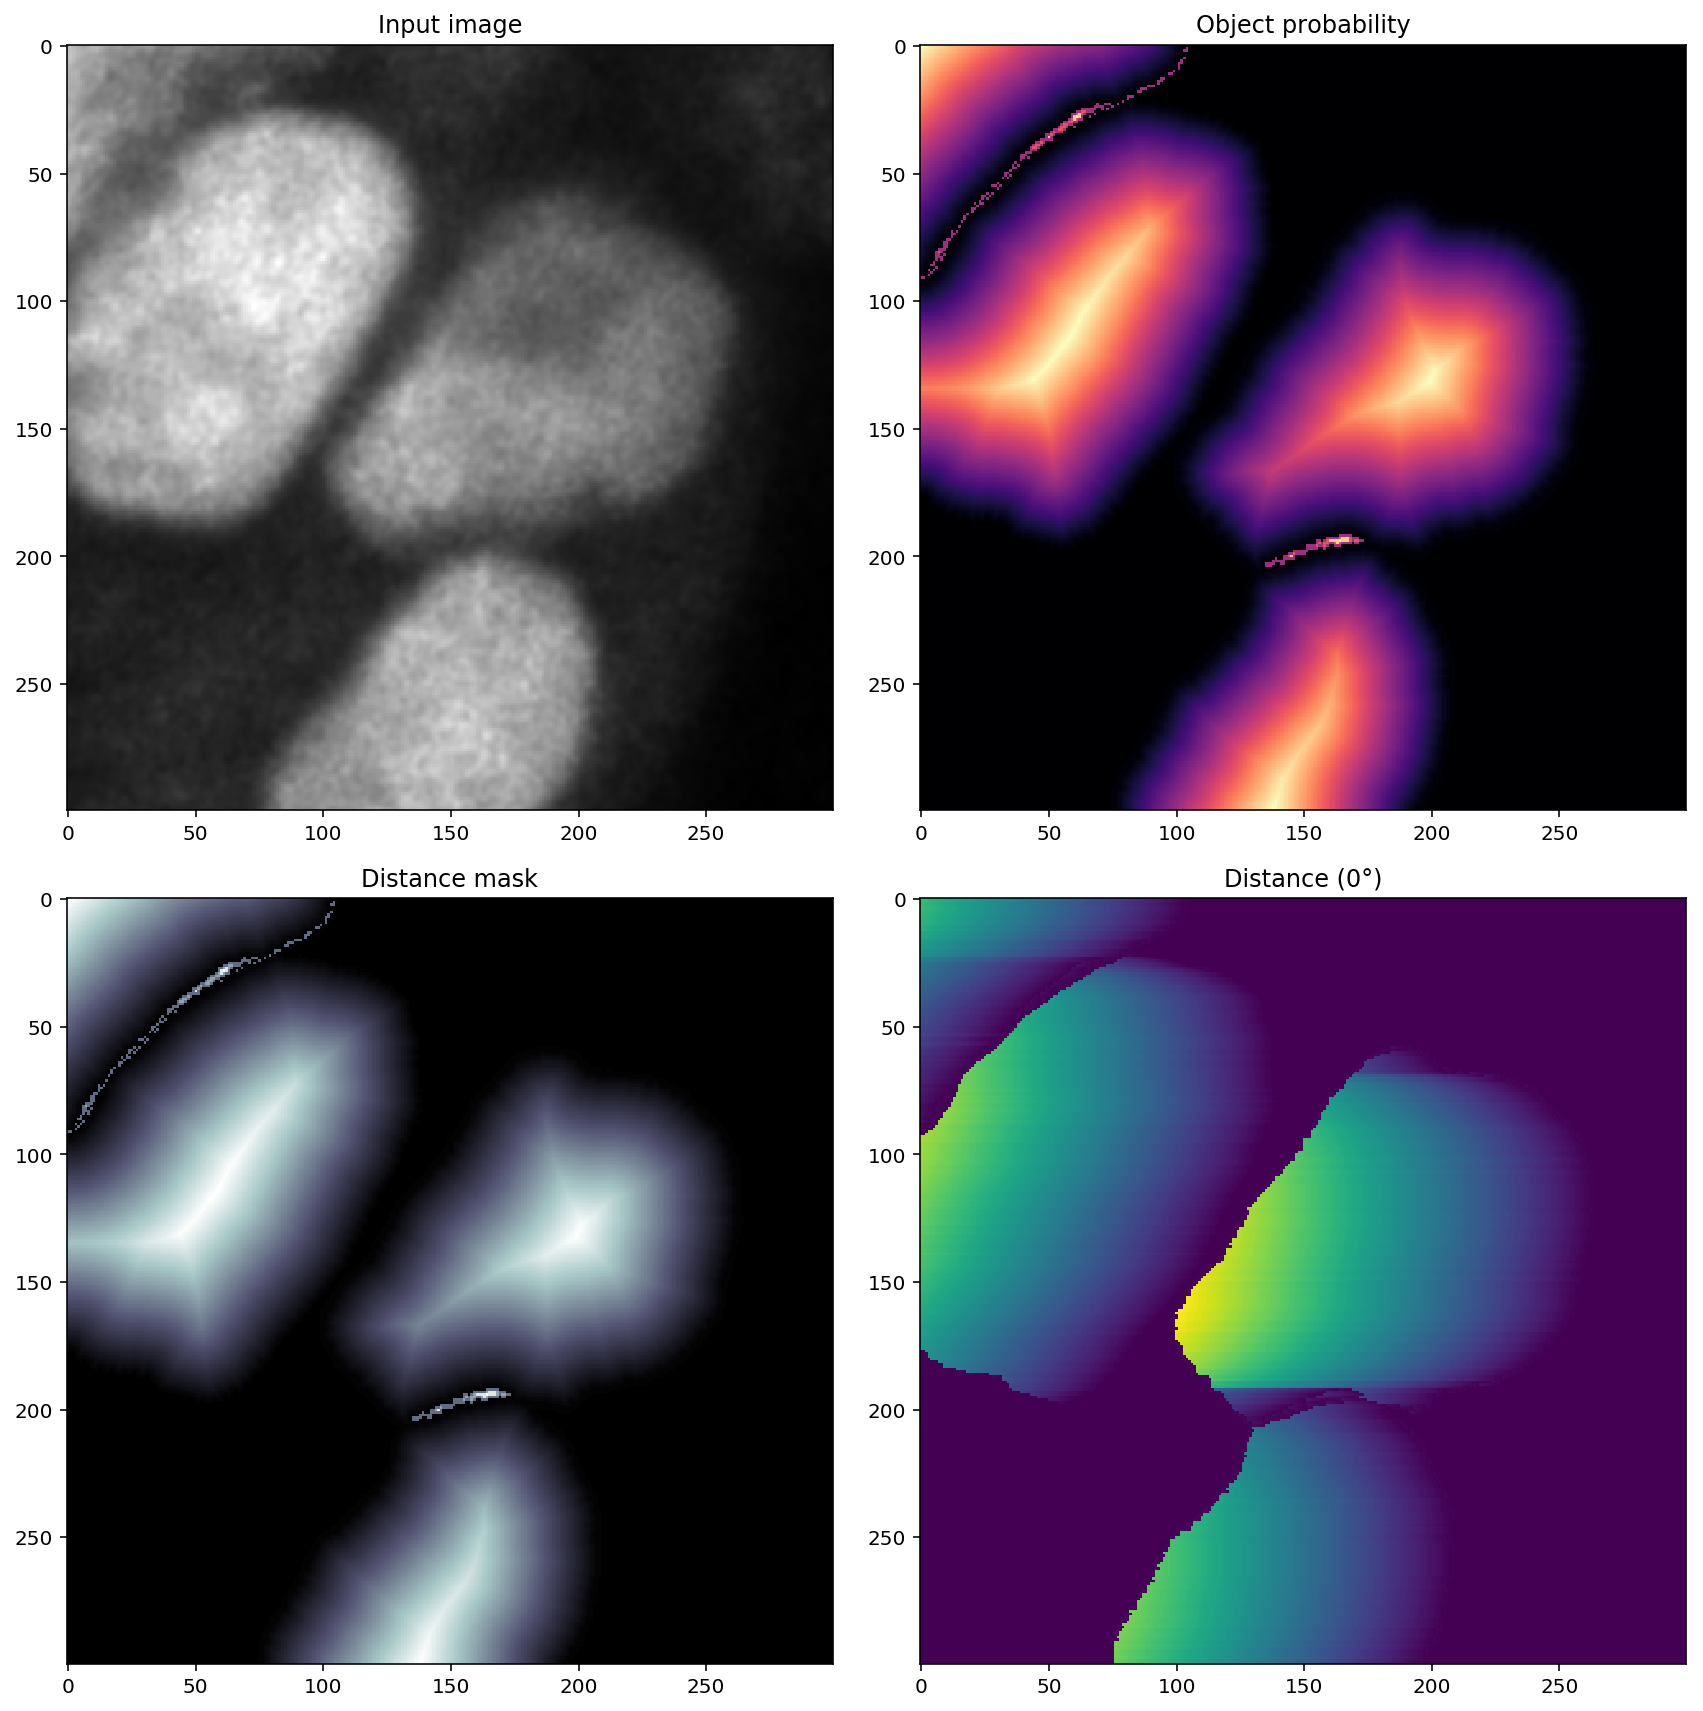

In [8]:
(img,dist_mask), (prob,dist) = data[0]

fig, ax = plt.subplots(2,2, figsize=(12,12))
for a,d,cm,s in zip(ax.flat, [img,prob,dist_mask,dist], ['gray','magma','bone','viridis'],
                    ['Input image','Object probability','Distance mask','Distance (0°)']):
    a.imshow(d[0,...,0],cmap=cm)
    a.set_title(s)
plt.tight_layout()
None;

In [9]:
print(Config.__doc__)

Configuration for a :class:`StarDist` model.

    Parameters
    ----------
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
        Convolution kernel size for all (U-Net) convolution layers.
    unet_n_filter_base : int
        Number of convolution kernels (feature channels) for first U-Net layer.
        Doubled after each down-sampling layer.
    net_conv_after_unet : int
        Number of extra convolution layers after U-Net (0 to disable).
    train_shape_completion : bool
        Train model to predict complete shapes for partially visible objects at image boundary.
    tr

In [13]:
conf = Config(train_batch_size=2, train_shape_completion=False, train_patch_size = (320,320), train_epochs = 50, 
              train_steps_per_epoch = 200, n_rays = 128, unet_n_filter_base = 64, unet_n_depth = 5 )
print(conf)
vars(conf)

Config(n_channel_in=1, n_rays=128, net_conv_after_unet=128, net_input_shape=(None, None, 1), train_batch_size=2, train_checkpoint='weights_best.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=50, train_learning_rate=0.0003, train_patch_size=(320, 320), train_reduce_lr={'patience': 10, 'factor': 0.5}, train_shape_completion=False, train_steps_per_epoch=200, train_tensorboard=True, unet_kernel_size=(3, 3), unet_n_depth=5, unet_n_filter_base=64)


{'n_channel_in': 1,
 'n_rays': 128,
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'train_batch_size': 2,
 'train_checkpoint': 'weights_best.h5',
 'train_completion_crop': 32,
 'train_dist_loss': 'mae',
 'train_epochs': 50,
 'train_learning_rate': 0.0003,
 'train_patch_size': (320, 320),
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'train_shape_completion': False,
 'train_steps_per_epoch': 200,
 'train_tensorboard': True,
 'unet_kernel_size': (3, 3),
 'unet_n_depth': 5,
 'unet_n_filter_base': 64}

In [14]:
model = StarDist(conf, name='StemCell128Rays', basedir='../models/Curiemodels')

/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/site-packages/stardist/model.py:272: UserWarning: output path for model already exists, files may be overwritten: /data/u934/service_imagerie/v_kapoor/anaconda2/bin/StarDist/StardistforCurie/models/StemCell128Rays
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


In [15]:
history = model.train(X_trn,Y_trn,validation_data=(X_val,Y_val))

Epoch 1/50
200/200 [==============================] - 179s 897ms/step - loss: 7.0753 - prob_loss: 0.6763 - dist_loss: 6.3990 - val_loss: 4.4128 - val_prob_loss: 0.3349 - val_dist_loss: 4.0779
Epoch 2/50
200/200 [==============================] - 170s 850ms/step - loss: 4.4905 - prob_loss: 0.2994 - dist_loss: 4.1911 - val_loss: 3.9960 - val_prob_loss: 0.2698 - val_dist_loss: 3.7262
Epoch 3/50
200/200 [==============================] - 172s 858ms/step - loss: 3.9726 - prob_loss: 0.3009 - dist_loss: 3.6717 - val_loss: 3.5391 - val_prob_loss: 0.2906 - val_dist_loss: 3.2485
Epoch 4/50
200/200 [==============================] - 172s 858ms/step - loss: 3.2462 - prob_loss: 0.3127 - dist_loss: 2.9335 - val_loss: 2.5845 - val_prob_loss: 0.2674 - val_dist_loss: 2.3172
Epoch 5/50
200/200 [==============================] - 173s 864ms/step - loss: 2.6872 - prob_loss: 0.2837 - dist_loss: 2.4036 - val_loss: 2.4589 - val_prob_loss: 0.3105 - val_dist_loss: 2.1484
Epoch 6/50
200/200 [====================

200/200 [==============================] - 170s 852ms/step - loss: 1.0917 - prob_loss: 0.2420 - dist_loss: 0.8497 - val_loss: 1.1479 - val_prob_loss: 0.2397 - val_dist_loss: 0.9082
Epoch 44/50
200/200 [==============================] - 171s 854ms/step - loss: 1.1055 - prob_loss: 0.2546 - dist_loss: 0.8509 - val_loss: 1.2376 - val_prob_loss: 0.2416 - val_dist_loss: 0.9960
Epoch 45/50
200/200 [==============================] - 170s 848ms/step - loss: 1.0599 - prob_loss: 0.2394 - dist_loss: 0.8205 - val_loss: 1.1523 - val_prob_loss: 0.2415 - val_dist_loss: 0.9108
Epoch 46/50
200/200 [==============================] - 171s 853ms/step - loss: 1.0771 - prob_loss: 0.2436 - dist_loss: 0.8335 - val_loss: 1.1546 - val_prob_loss: 0.2418 - val_dist_loss: 0.9128
Epoch 47/50
200/200 [==============================] - 171s 855ms/step - loss: 1.0598 - prob_loss: 0.2393 - dist_loss: 0.8205 - val_loss: 1.1477 - val_prob_loss: 0.2408 - val_dist_loss: 0.9069
Epoch 48/50
200/200 [==========================

['dist_loss', 'loss', 'lr', 'prob_loss', 'val_dist_loss', 'val_loss', 'val_prob_loss']


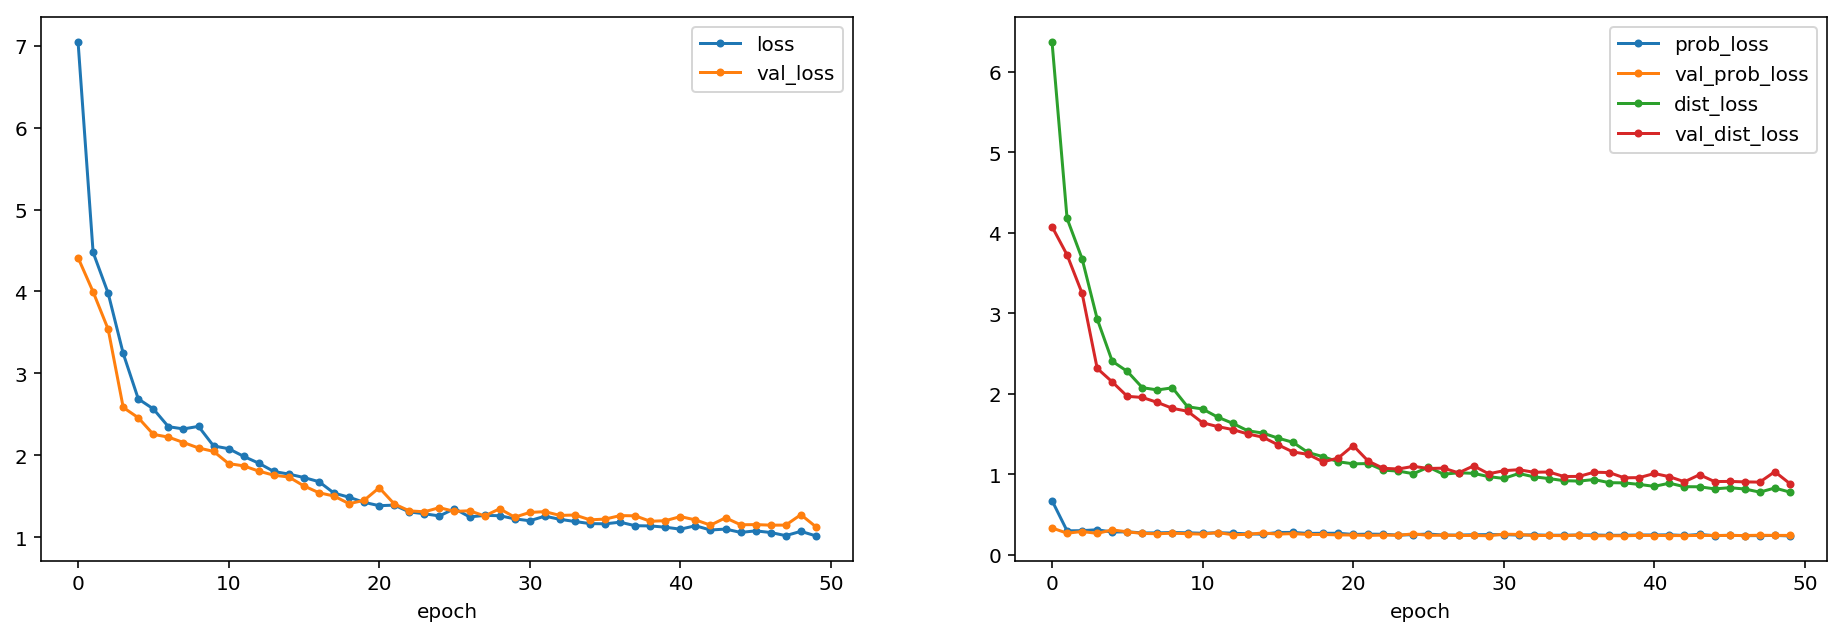

In [16]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['prob_loss','val_prob_loss','dist_loss','val_dist_loss']);